[Text classification with a RNN Tutorial in Tensorflow 2.0](https://www.tensorflow.org/tutorials/text/text_classification_rnn)

In [0]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import time

# Set up input pipeline

The IMDB large movie review dataset is a binary classification dataset—all the reviews have either a positive or negative sentiment.
We will download the dataset using TensorFlow Datasets.

In [2]:
dataset, info = tfds.load("imdb_reviews/subwords8k", with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset["train"], dataset["test"]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete168RMN/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete168RMN/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete168RMN/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [0]:
encoder = info.features["text"].encoder

In [4]:
print(f"Vocabulary size: {encoder.vocab_size}")

Vocabulary size: 8185


This text encoder will reversibly encode any string, falling back to byte-encoding if necessary

In [5]:
encoded_string = encoder.encode("Hello Tensorflow, let's see how you encode this sentence.")
print(encoded_string)
decoded_string = encoder.decode(encoded_string)
print(decoded_string)

[4025, 222, 6307, 2327, 2934, 2, 920, 7968, 8, 86, 113, 37, 6213, 510, 14, 7745, 7975]
Hello Tensorflow, let's see how you encode this sentence.


In [6]:
for index in encoded_string:
  print(f"{index} --> {encoder.decode([index])}")

4025 --> Hell
222 --> o 
6307 --> Ten
2327 --> sor
2934 --> flow
2 --> , 
920 --> let
7968 --> '
8 --> s 
86 --> see 
113 --> how 
37 --> you 
6213 --> enco
510 --> de 
14 --> this 
7745 --> sentence
7975 --> .


# Prepare data for training

We will use the padded_batch introduce in the Word embeddings tutorial to create batches of these encoded strings.

In [0]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [0]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)
test_dataset = test_dataset.padded_batch(BATCH_SIZE)

# Create the model

We will use a Sequential model that starts with an Embedding layer and then goes straight to a bi-directional LSTM. Finally, there is a dense layer with 64 units that is connected to the final dense layer with a single neuron, used for the classification task.

In [0]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(input_dim=encoder.vocab_size, output_dim=64, mask_zero=True),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64)),
  tf.keras.layers.Dense(units=64, activation="relu"),
  tf.keras.layers.Dense(units=1)                                    
])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          523840    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 598,209
Trainable params: 598,209
Non-trainable params: 0
_________________________________________________________________


**NOTE**: If we wanted to use the stateful RNN layer, we should have built the model with Keras functional API or model subclassing so that the RNN layer states can be retrieved and used. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

In [0]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy'],
)

# Train the model

In [12]:
history = model.fit(
    train_dataset, 
    epochs=10,
    validation_data=test_dataset,
    validation_steps=30,
)

Epoch 1/10
391/391 [==============================] - 133s 340ms/step - loss: 0.6315 - accuracy: 0.5906 - val_loss: 0.4689 - val_accuracy: 0.8078
Epoch 2/10
391/391 [==============================] - 129s 330ms/step - loss: 0.3655 - accuracy: 0.8475 - val_loss: 0.3550 - val_accuracy: 0.8344
Epoch 3/10
391/391 [==============================] - 129s 331ms/step - loss: 0.2640 - accuracy: 0.8974 - val_loss: 0.3334 - val_accuracy: 0.8609
Epoch 4/10
391/391 [==============================] - 129s 331ms/step - loss: 0.2099 - accuracy: 0.9232 - val_loss: 0.3255 - val_accuracy: 0.8542
Epoch 5/10
391/391 [==============================] - 129s 330ms/step - loss: 0.1774 - accuracy: 0.9379 - val_loss: 0.3439 - val_accuracy: 0.8687
Epoch 6/10
391/391 [==============================] - 129s 330ms/step - loss: 0.1545 - accuracy: 0.9461 - val_loss: 0.3526 - val_accuracy: 0.8635
Epoch 7/10
391/391 [==============================] - 129s 329ms/step - loss: 0.1314 - accuracy: 0.9570 - val_loss: 0.3807 -

In [13]:
test_loss, test_acc = model.evaluate(test_dataset)

391/391 [==============================] - 61s 155ms/step - loss: 0.4453 - accuracy: 0.8578


We will now create the inference function for a given sample

In [0]:
def encode_sample(sample_pred_text):
  encoded_sample = encoder.encode(sample_pred_text)
  encoded_sample_tensor = tf.constant(encoded_sample, dtype=tf.float32)
  return encoded_sample_tensor

@tf.function
def model_predict(encoded_sample):
  logits = model(tf.expand_dims(encoded_sample, axis=0))
  predicted_value = tf.sigmoid(logits)
  return predicted_value

In [20]:
# Predict on a positive sample
sample_pred_text = "The movie was cool. The animation and the graphics" \
                   " were out of this world and, because of that, " \
                   "I would definitely recommend this movie!"
print(f"Text to predict: \n{sample_pred_text}")
encoded_sample = encode_sample(sample_pred_text)
prediction = model_predict(encoded_sample)
start = time.time()
print(f"Prediction: {prediction[0][0]} [took {time.time() - start} s]")

Text to predict: 
The movie was cool. The animation and the graphics were out of this world and, because of that, I would definitely recommend this movie!
Prediction: 0.9197081923484802 [took 0.0009548664093017578 s]


In [22]:
# Predict on a negative sample
sample_pred_text = "What an awful movie! I expected much more from this director." \
                   " The plot was ok, but the actors and graphics were terrible..."
print(f"Text to predict: \n{sample_pred_text}")
encoded_sample = encode_sample(sample_pred_text)
prediction = model_predict(encoded_sample)
start = time.time()
print(f"Prediction: {prediction[0][0]} [took {time.time() - start} s]")

Text to predict: 
What an awful movie! I expected much more from this director. The plot was ok, but the actors and graphics were terrible...
Prediction: 0.009310523048043251 [took 0.0006847381591796875 s]


In [24]:
# Prediction on a neutral sample
sample_pred_text = "I would say this is an ok movie"
print(f"Text to predict: \n{sample_pred_text}")
encoded_sample = encode_sample(sample_pred_text)
prediction = model_predict(encoded_sample)
start = time.time()
print(f"Prediction: {prediction[0][0]} [took {time.time() - start} s]")

Text to predict: 
I would say this is an ok movie
Prediction: 0.4155127704143524 [took 0.0007112026214599609 s]


Let's now plot the training and evaluation graphs

In [0]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

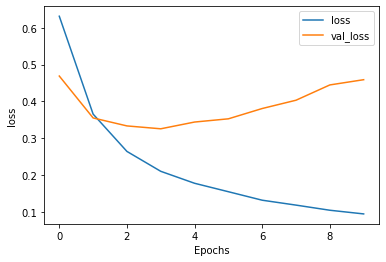

In [26]:
plot_graphs(history, "loss")

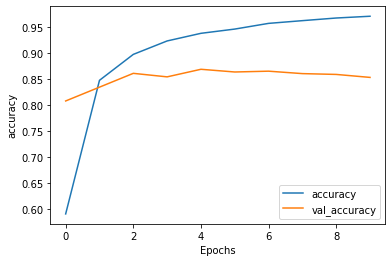

In [27]:
plot_graphs(history, "accuracy")

# Stack two or more LSTM layers

We can set up the LSTM layers so that they return the full sequences using the `return_sequences` options.

In [29]:
model_v2 = tf.keras.Sequential([
  tf.keras.layers.Embedding(encoder.vocab_size, 64, mask_zero=True),
  tf.keras.layers.LSTM(units=64, return_sequences=True),
  tf.keras.layers.LSTM(units=32),
  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(1, activation="sigmoid"),
])
model_v2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 571,457
Trainable params: 571,457
Non-trainable params: 0
________________________________________________

In [0]:
model_v2.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=[
      tf.keras.metrics.Precision(),
      tf.keras.metrics.Recall()
    ],
)

In [39]:
history = model_v2.fit(
    train_dataset,
    epochs=10,
    validation_data=test_dataset,
    validation_steps=30
)

Epoch 1/10
391/391 [==============================] - 122s 311ms/step - loss: 0.5434 - precision_1: 0.7509 - recall_1: 0.6871 - val_loss: 0.4203 - val_precision_1: 0.9049 - val_recall_1: 0.7121
Epoch 2/10
391/391 [==============================] - 117s 299ms/step - loss: 0.3067 - precision_1: 0.8832 - recall_1: 0.8877 - val_loss: 0.3318 - val_precision_1: 0.8848 - val_recall_1: 0.8576
Epoch 3/10
391/391 [==============================] - 116s 297ms/step - loss: 0.2376 - precision_1: 0.9168 - recall_1: 0.9184 - val_loss: 0.3349 - val_precision_1: 0.8927 - val_recall_1: 0.8350
Epoch 4/10
391/391 [==============================] - 119s 305ms/step - loss: 0.1950 - precision_1: 0.9352 - recall_1: 0.9370 - val_loss: 0.3557 - val_precision_1: 0.8805 - val_recall_1: 0.8535
Epoch 5/10
391/391 [==============================] - 118s 302ms/step - loss: 0.1733 - precision_1: 0.9450 - recall_1: 0.9460 - val_loss: 0.3794 - val_precision_1: 0.8678 - val_recall_1: 0.8607
Epoch 6/10
391/391 [==========

In [41]:
test_loss, test_precision, test_recall = model_v2.evaluate(test_dataset)

391/391 [==============================] - 61s 155ms/step - loss: 0.4928 - precision_1: 0.8772 - recall_1: 0.8017


In [42]:
print(f"Test Loss: {test_loss}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")

Test Loss: 0.49279069900512695
Test Precision: 0.8771883845329285
Test Recall: 0.8016800284385681


In [0]:
@tf.function
def model_v2_predict(encoded_sample):
  return model_v2(tf.expand_dims(encoded_sample, axis=0))

In [47]:
# Predict on a positive sample
sample_pred_text = "bla bla bla bla bla"
print(f"Text to predict: \n{sample_pred_text}")
encoded_sample = encode_sample(sample_pred_text)
prediction_v2 = model_v2_predict(encoded_sample)
start = time.time()
print(f"Prediction: {prediction[0][0]} [took {time.time() - start} s]")

Text to predict: 
bla bla bla bla bla
Prediction: 0.4155127704143524 [took 0.0008237361907958984 s]


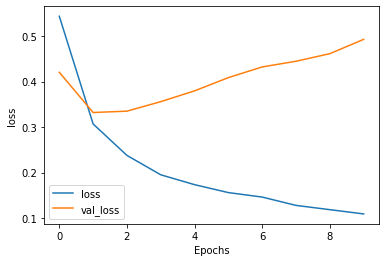

In [48]:
plot_graphs(history, "loss")

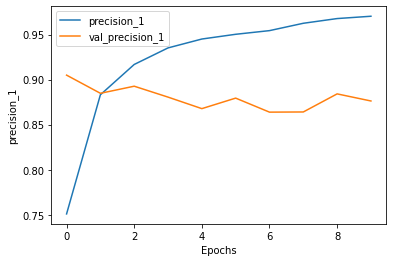

In [52]:
plot_graphs(history, "precision_1")

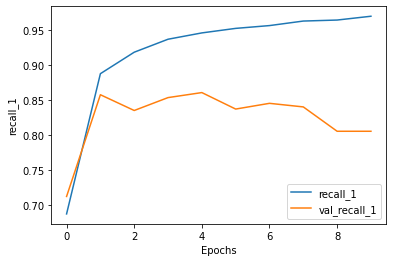

In [54]:
plot_graphs(history, "recall_1")